In [3]:
import pandas as pd
from utils import Timer, copy_file
from joblib import Parallel, delayed
from traj2grid import Traj2Grid
import json
import traj_dist.distance as tdist
from logging import raiseExceptions
from args import *
import numpy as np
import time

timer = Timer()



In [8]:
file_path = "data/1m_gps_20161101"
dict_path = "data/str_grid2idx_400.json"
full = False
metric="edr"
eps=eps_400_eu

# read data
timer.tik()
df = pd.DataFrame(pd.read_csv(file_path, header=None))
df.columns = ["name", "order_id", "time", "lon", "lat"]  # lon经度 lat纬度
timer.tok("read {}".format(file_path))

# load dict & set converter
str_grid2idx = json.load(open(dict_path))
t2g = Traj2Grid(row_num, column_num, min_lon, min_lat, max_lon, max_lat)
grid2idx = {eval(g): str_grid2idx[g] for g in list(str_grid2idx)}
t2g.set_vocab(grid2idx)
timer.tok("load dict")


def group_concat(name, group: pd.DataFrame):
    origin_traj = [((row["lon"]), row["lat"])
                   for index, row in group.iterrows()]
    traj_1d = t2g.convert1d(origin_traj)
    series = pd.Series({
        "order_id": name,
        "origin_trajs": origin_traj,
        "trajs": traj_1d,
        "len": len(origin_traj),
        "max_time_diff": group["time"].diff().max(),
        "max_lon_diff": group["lon"].diff().max(),
        "max_lat_diff": group["lat"].diff().max(),
    })
    return series


# group-apply
res = Parallel(n_jobs=6)(delayed(group_concat)(name, group)
                         for name, group in df.groupby("order_id"))
df = pd.DataFrame(res)
timer.tok("group-apply")



tik start
read data/1m_gps_20161101 done, 0.75s after tik start
load dict done, 1.26s after tik start
group-apply done, 11.509s after tik start


In [34]:
# filter
t_diff_limit = 20
lon_lat_diff_limit = 0.005
length_limit = 50
dff = df[
    (df["max_time_diff"] < t_diff_limit) &
    (df["max_lon_diff"] + df["max_lat_diff"] < lon_lat_diff_limit) &
    (df["len"] > length_limit)
]
print(f"剩{len(dff)}/{len(df)}条，筛掉{round(100 - 100 * len(dff) / len(df))}%")


剩3407/5650条，筛掉40%


<AxesSubplot:>

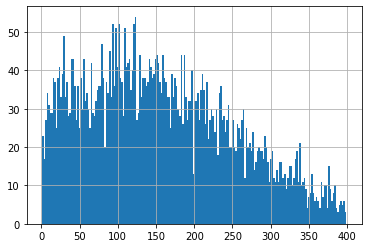

In [28]:
df[df['len']<400]['len'].hist(bins=200)

In [ ]:
# calculate distance
origin_trajs = df["origin_trajs"].to_list()
arr_trajs = [np.array(origin_traj) for origin_traj in origin_trajs]
length = len(arr_trajs)
dis_matrix = np.zeros((length, length))
if metric == "edr":
    def cal_dis(i, j, x, y, n):
        dis = tdist.edr(x, y, eps=eps)
        if i == j + 1:
            timer.tok(f'{i}-{round((i * i) / (n * n) * 100, 2)}%')
        return i, j, dis

        res = Parallel(n_jobs=44)(
            delayed(cal_dis)(i, j, arr_trajs[i], arr_trajs[j], length - 1) for i in range(length) for j in range(i))
        timer.tok("calculate distance")
        for (i, j, dis) in res:
            dis_matrix[i, j] = dis
            dis_matrix[j, i] = dis
else:
    raiseExceptions("metric {} is not supported".format(metric))
sorted_index = np.argsort(dis_matrix, axis=1)
dict_save = {'trajs': df["trajs"].to_list(
), "sorted_index": sorted_index.tolist(), 'origin_trajs': origin_trajs}
if full:
    dict_save["dis_matrix"] = dis_matrix.tolist()
    json.dump(dict_save, open(file_path + "_dataset_full.json", "w"))
else:
    json.dump(dict_save, open(file_path + "_dataset.json", "w"))
timer.tok("save")
